In this notebook, I use neural networks to classify the IMDB reviews. Following are the steps I made:
* organize the folder to work with keras
* use keras TextVectorization to convert the data to bag-of-word format
* train and test with 1-gram and bigram models
* monitor the evaluation metrics
* regularize to handle overfitting

In [31]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import os, shutil, pathlib, random

import warnings
warnings.filterwarnings("ignore")

For training with keras, I'll need to organize the dataset in certain folder structure. Then I can directly use keras utils library to create the datasets for train, test and validation.

In [2]:
basedir = pathlib.Path('aclImdb')
train_dir = basedir/'train'
test_dir = basedir/'test'
val_dir = basedir/'val'
for category in ('neg', 'pos'):
    if not os.path.exists(val_dir/category):
        os.makedirs(val_dir/category)
    files = os.listdir(train_dir/category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir/category/fname, val_dir/category/fname)

In [3]:
batch_size = 32
train_ds = keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 16000 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Checking one instance of the dataset

In [4]:
for inputs, targets in train_ds:
    print('input.shape:', inputs.shape)
    print('input.dtype:', inputs.dtype)
    print('target.shape:', targets.shape)
    print('target.dtype:', targets.dtype)
    print('input[0]:', inputs[0])
    print('target[0]:', targets[0])
    break

input.shape: (32,)
input.dtype: <dtype: 'string'>
target.shape: (32,)
target.dtype: <dtype: 'int32'>
input[0]: tf.Tensor(b"I'm grateful for one thing and one thing only - that this woman will now be thousands of miles away on an entirely different continent!!! Yay!!! This programme summed up perfectly just how obsessed Victoria Beckham has become with whoring herself and her family out to the media in the name of self promotion and 'Brand f*cking Beckham'.<br /><br />A few years ago I used to really like 'Posh and Becks', I still very much admire David's talent, but I have no respect for him anymore. How can you respect someone who has his wife's hand shoved up his backside working him like a puppet.<br /><br />It was clear the hand of Victoria was all over Beckham's premature departure from Manchester United and now the same thing has happened at Real Madrid. I hope Beckham can live with the fact that although he may be earning squillions of pounds - he's sold his soul for the America

##### Creating vocabulary
- keras TextVectorization will take care of the tokenization part
- We'll create the vocabulary using only the train dataset and use this vocabulary set for all the datasets including validation and test.

In [5]:
def get_vectorized_dataset(train_ds, val_ds, test_ds, output_mode, ngrams=2, max_token=20000):
    
    text_vectorization = TextVectorization(
        ngrams = ngrams,
        max_tokens = 20000,
        output_mode = output_mode
    ) 
    # separating the text part to pass it to the TextVectorization
    text_only_train_ds = train_ds.map(lambda x,y : x)
    text_vectorization.adapt(text_only_train_ds)
    
    review_vocab = text_vectorization.get_vocabulary()
    print("Length of the vocabulary: ", len(review_vocab))
    print("First 10 words in the vocabulary: ", review_vocab[:10])
    print("Last 10 words in the vocabulary: ", review_vocab[-10:])
    
    vectorized_train_ds = train_ds.map(lambda x,y : (text_vectorization(x), y),
                                    num_parallel_calls = 4)
    vectorized_val_ds = val_ds.map(lambda x,y : (text_vectorization(x), y),
                                        num_parallel_calls = 4)
    vectorized_test_ds = test_ds.map(lambda x,y : (text_vectorization(x), y),
                                    num_parallel_calls = 4)
    
    return vectorized_train_ds, vectorized_val_ds, vectorized_test_ds

In [1]:
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))    
    x = layers.Dense(hidden_dim, activation='relu')(inputs)  
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

#### 1-gram model

Prepapring dataset for 1-gram model
* passing ngrams = 1
* there are a number of choices for the output_mode, I am using muti-hot encoding here

In [40]:
vectorized_train_ds, vectorized_val_ds, vectorized_test_ds = get_vectorized_dataset(train_ds, val_ds, test_ds, output_mode='multi_hot', ngrams=1, max_token=20000)

Length of the vocabulary:  20000
First 10 words in the vocabulary:  ['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']
Last 10 words in the vocabulary:  ['duplicitous', 'duos', 'dunk', 'duller', 'dues', 'ducktales', 'dtv', 'drying', 'drool', 'drones']


##### create 1-gram model

In [39]:
model = get_model()
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_16 (Dense)            (None, 16)                320016    
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


##### Train the 1-gram model

In [42]:
callbacks = [
    keras.callbacks.ModelCheckpoint('binary_1gram.m', save_best_only=True)
]
history_1gram = model.fit(vectorized_train_ds, 
         validation_data=vectorized_val_ds,
         epochs=10,
         callbacks=callbacks)

Epoch 1/10
496/500 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8632

INFO:tensorflow:Assets written to: binary_1gram.m\assets


INFO:tensorflow:Assets written to: binary_1gram.m\assets


500/500 [==============================] - 11s 20ms/step - loss: 0.3422 - accuracy: 0.8636 - val_loss: 0.2846 - val_accuracy: 0.8853
Epoch 2/10
500/500 [==============================] - 9s 18ms/step - loss: 0.1888 - accuracy: 0.9286 - val_loss: 0.2961 - val_accuracy: 0.8856
Epoch 3/10
500/500 [==============================] - 9s 18ms/step - loss: 0.1399 - accuracy: 0.9499 - val_loss: 0.3193 - val_accuracy: 0.8858
Epoch 4/10
500/500 [==============================] - 9s 18ms/step - loss: 0.1106 - accuracy: 0.9620 - val_loss: 0.3602 - val_accuracy: 0.8801
Epoch 5/10
500/500 [==============================] - 9s 18ms/step - loss: 0.0902 - accuracy: 0.9689 - val_loss: 0.3827 - val_accuracy: 0.8781
Epoch 6/10
500/500 [==============================] - 9s 19ms/step - loss: 0.0750 - accuracy: 0.9747 - val_loss: 0.4114 - val_accuracy: 0.8770
Epoch 7/10
500/500 [==============================] - 10s 19ms/step - loss: 0.0623 - accuracy: 0.9797 - val_loss: 0.4605 - val_accuracy: 0.8716
Epoch 8/

##### Test the 1-gram model performance on the test dataset 

In [43]:
model = keras.models.load_model("binary_1gram.m")
print(f"Test acc of binary_1gram model: {model.evaluate(vectorized_test_ds)[1]:.3f}")

782/782 [==============================] - 7s 8ms/step - loss: 0.2854 - accuracy: 0.8853
Test acc of binary_1gram model: 0.885


> **Note: the 1-gram model is perfomring better than the baseline model in terms of accuracy! Next I'll check with bigram model to see if it further improves the accuracy.**

##### Bigram model
Prepapring dataset for bigram model
* passing ngrams = 2
* I am choosing tf-idf as the output_mode

In [44]:
# vectorized_train_ds, vectorized_val_ds, vectorized_test_ds = get_vectorized_dataset(train_ds, val_ds, test_ds, output_mode='multi_hot', ngrams=2, max_token=20000)
vectorized_train_ds, vectorized_val_ds, vectorized_test_ds = get_vectorized_dataset(train_ds, val_ds, test_ds, output_mode='tf_idf', ngrams=2, max_token=20000)

Length of the vocabulary:  20000
First 10 words in the vocabulary:  ['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']
Last 10 words in the vocabulary:  ['whatever you', 'what with', 'were there', 'were talking', 'wears a', 'we think', 'we did', 'ways of', 'way over', 'was obvious']


##### Create and train the bigram model

In [48]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint('bigram_model.m', save_best_only=True)
]
history_bigram = model.fit(vectorized_train_ds, 
         validation_data=vectorized_val_ds,
         epochs=10,
         callbacks=callbacks)

Epoch 1/10
496/500 [============================>.] - ETA: 0s - loss: 0.4098 - accuracy: 0.8486

INFO:tensorflow:Assets written to: bigram_model.m\assets


INFO:tensorflow:Assets written to: bigram_model.m\assets


500/500 [==============================] - 11s 20ms/step - loss: 0.4079 - accuracy: 0.8494 - val_loss: 0.2900 - val_accuracy: 0.8952
Epoch 2/10
500/500 [==============================] - 10s 20ms/step - loss: 0.1587 - accuracy: 0.9446 - val_loss: 0.3295 - val_accuracy: 0.8939
Epoch 3/10
500/500 [==============================] - 13s 27ms/step - loss: 0.0871 - accuracy: 0.9709 - val_loss: 0.3882 - val_accuracy: 0.8880
Epoch 4/10
500/500 [==============================] - 14s 28ms/step - loss: 0.0443 - accuracy: 0.9860 - val_loss: 0.4520 - val_accuracy: 0.8847
Epoch 5/10
500/500 [==============================] - 14s 28ms/step - loss: 0.0233 - accuracy: 0.9930 - val_loss: 0.5444 - val_accuracy: 0.8806
Epoch 6/10
500/500 [==============================] - 14s 29ms/step - loss: 0.0209 - accuracy: 0.9948 - val_loss: 0.5741 - val_accuracy: 0.8812
Epoch 7/10
500/500 [==============================] - 14s 28ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.6376 - val_accuracy: 0.8779
Epo

##### Test the bigram model accuracy on test dataset

In [49]:
model = keras.models.load_model("bigram_model.m")
print(f"Test acc of bigram model: {model.evaluate(vectorized_test_ds)[1]:.3f}")

782/782 [==============================] - 10s 13ms/step - loss: 0.3013 - accuracy: 0.8913
Test acc of bigram model: 0.891


> **Yes the bigram model could further improve the accuracy! But before getting too comfortable with the result, I need to monitor the training history for possible overfitting scenario. Let's plot the loss over time during training.** 

In [50]:
def plot_func(history, var):
    hist = history.history
    train_var = hist[var]
    val_var = hist['val_'+var]
    epochs = range(1, len(train_var)+1)
    plt.plot(epochs, train_var, label='Training '+var)
    plt.plot(epochs, val_var, label='Validation '+var)
    plt.title('Training and validation '+var)
    plt.xlabel('Epochs')
    plt.ylabel(var)
    plt.show()

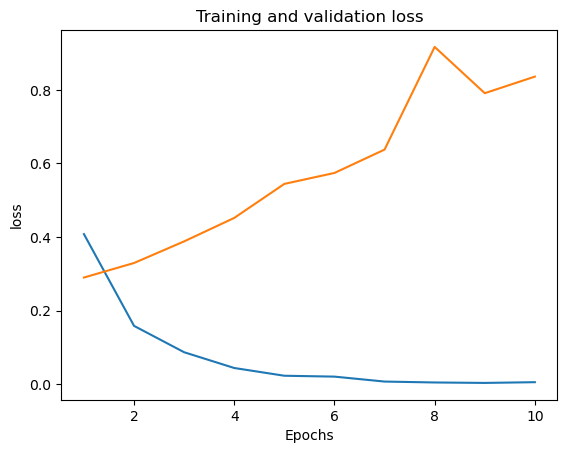

In [51]:
plot_func(history_bigram, 'loss')

>**We can clearly see that the training loss is decreasing but the validation loss is on the rise. This is a classic case of overfitting.  I'll regularize my model so that it does not overfit the training data. Adding dropout layers to my model for regularization.**

In [2]:
def get_model_with_dropout(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dropout(0.5)(inputs)
    x = layers.Dense(hidden_dim, activation='relu')(x)
    # x = layers.Dense(hidden_dim, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

##### Creating and training model with dropout layer

In [55]:
model = get_model_with_dropout()
# model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint('bigram_model_with_dropout.m', save_best_only=True)
]
history_bigram_with_dropout = model.fit(vectorized_train_ds, 
         validation_data=vectorized_val_ds,
         epochs=10,
         callbacks=callbacks)

Epoch 1/10
498/500 [============================>.] - ETA: 0s - loss: 0.5879 - accuracy: 0.7061

INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


500/500 [==============================] - 18s 35ms/step - loss: 0.5876 - accuracy: 0.7061 - val_loss: 0.3378 - val_accuracy: 0.8799
Epoch 2/10
498/500 [============================>.] - ETA: 0s - loss: 0.4331 - accuracy: 0.8213

INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


500/500 [==============================] - 15s 30ms/step - loss: 0.4331 - accuracy: 0.8212 - val_loss: 0.2941 - val_accuracy: 0.8876
Epoch 3/10
499/500 [============================>.] - ETA: 0s - loss: 0.3846 - accuracy: 0.8506

INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


500/500 [==============================] - 15s 31ms/step - loss: 0.3842 - accuracy: 0.8507 - val_loss: 0.2838 - val_accuracy: 0.8896
Epoch 4/10
500/500 [==============================] - 16s 32ms/step - loss: 0.3570 - accuracy: 0.8661 - val_loss: 0.2867 - val_accuracy: 0.8901
Epoch 5/10
500/500 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.8764

INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


500/500 [==============================] - 17s 33ms/step - loss: 0.3281 - accuracy: 0.8764 - val_loss: 0.2770 - val_accuracy: 0.8928
Epoch 6/10
500/500 [==============================] - 14s 29ms/step - loss: 0.3182 - accuracy: 0.8824 - val_loss: 0.2803 - val_accuracy: 0.8941
Epoch 7/10
500/500 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8882

INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


500/500 [==============================] - 16s 32ms/step - loss: 0.3040 - accuracy: 0.8882 - val_loss: 0.2729 - val_accuracy: 0.8962
Epoch 8/10
500/500 [==============================] - 15s 29ms/step - loss: 0.2913 - accuracy: 0.8907 - val_loss: 0.2895 - val_accuracy: 0.8910
Epoch 9/10
499/500 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8923

INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


500/500 [==============================] - 16s 31ms/step - loss: 0.2932 - accuracy: 0.8923 - val_loss: 0.2695 - val_accuracy: 0.8999
Epoch 10/10
499/500 [============================>.] - ETA: 0s - loss: 0.2946 - accuracy: 0.8918

INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


INFO:tensorflow:Assets written to: bigram_model_with_dropout.m\assets


500/500 [==============================] - 16s 31ms/step - loss: 0.2942 - accuracy: 0.8920 - val_loss: 0.2684 - val_accuracy: 0.8992


##### Testing the model with dropout layer

In [56]:
model = keras.models.load_model("bigram_model_with_dropout.m")
print(f"Test acc of bigram model with dropout: {model.evaluate(vectorized_test_ds)[1]:.3f}")

782/782 [==============================] - 10s 13ms/step - loss: 0.2664 - accuracy: 0.9001
Test acc of bigram model with dropout: 0.900


##### Plotting the train and validation loss

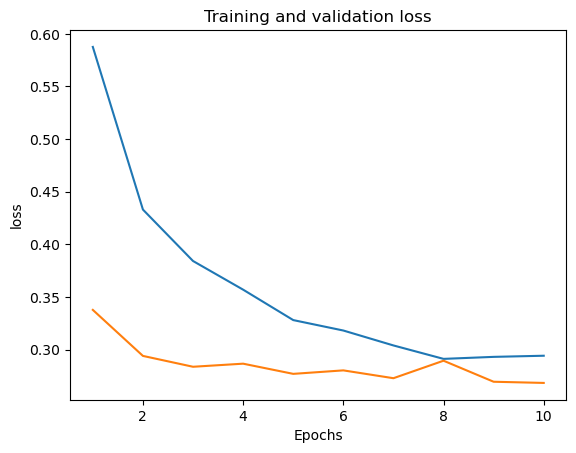

In [57]:
plot_func(history_bigram_with_dropout, 'loss')

> **These curves look much better than the earlier model! Also, our accuracy has increased to 90% at this time. We can try for further imrpovement by using word embeddings.**